In [53]:

import networkx as nx
import pandas as pd
import numpy as np
import pulp
import itertools
import os
import pickle
from collections import deque
from tqdm import tqdm
import osmnx as ox
import matplotlib.pyplot as plt

In [54]:
with open('graph_from_routes_wd.pkl', 'rb') as f:
    graph_from_routes = pickle.load(f)
nyc_graph = graph_from_routes.copy()
# Retrieve the street network for Manhattan, but simplified
graph = ox.graph_from_place("Manhattan, New York, USA", network_type="drive_service", custom_filter='["highway"~"primary|secondary"]')


In [55]:
len(graph_from_routes.nodes())

482

In [56]:
len(graph_from_routes.edges())

1622

In [6]:
# %%
import math
edge_info = {}
l = 50 #km/h#/ 3600#m/h
# Iterate over edges and add distances to the dictionary
for u, v, d in nyc_graph.edges(data=True):
    edge_info[(u, v)] = [
        int(d["length"]),
        d["length"] / d["maxspeed"] if not math.isnan(d["maxspeed"]) else d["length"]/l,
        50
    ]

In [7]:
df = pd.read_csv("dataset/finished_dataset.csv")

In [8]:
unique_pickups = list(np.unique(df["pickup_graph_node"]))
unique_dropoffs = list(np.unique(df["dropoff_graph_node"]))
important_points= list(set(unique_dropoffs+unique_pickups))


In [9]:
def merge_consecutive_nodes(graph):
    nodes_to_remove = []
    for u, v in graph.edges():
        if len(graph[u]) == 1 and len(graph[v]) == 1:
            # Merge u and v into a single node
            graph = nx.contracted_nodes(graph, u, v, self_loops=False)
            nodes_to_remove.append(u)
    graph.remove_nodes_from(nodes_to_remove)
    return graph

# Rule 2: Merge parallel edges between two nodes into a single edge
def merge_parallel_edges(graph):
    parallel_edges = list(graph.edges())
    for u, v in parallel_edges:
        if graph.number_of_edges(u, v) > 1:
            # Merge parallel edges into a single edge
            graph[u][v]['weight'] = sum(d['weight'] for d in graph[u][v].values())
            graph.remove_edges_from([(u, v)])
    return graph

In [10]:
nyc_graph = merge_consecutive_nodes(nyc_graph)
nyc_graph = merge_parallel_edges(nyc_graph)

In [11]:
len(nyc_graph.edges())

1622

In [12]:
def remove_dead_ends(graph, important_points):
    dead_ends = [node for node in graph.nodes() if graph.degree(node) == 1 and node not in important_points]
    while dead_ends:
        for node in dead_ends:
            if graph.degree(node) == 1:
                # Get the neighbor of the dead end node
                neighbor = list(graph.neighbors(node))[0]
                # Remove the dead end node
                graph.remove_node(node)
                # Recalculate dead ends
                dead_ends = [n for n in graph.nodes() if graph.degree(n) == 1 and n not in important_points]
                break
    return graph

# Applying dead end removal
nyc_graph = remove_dead_ends(nyc_graph, important_points)

In [13]:
len(nyc_graph.nodes())

482

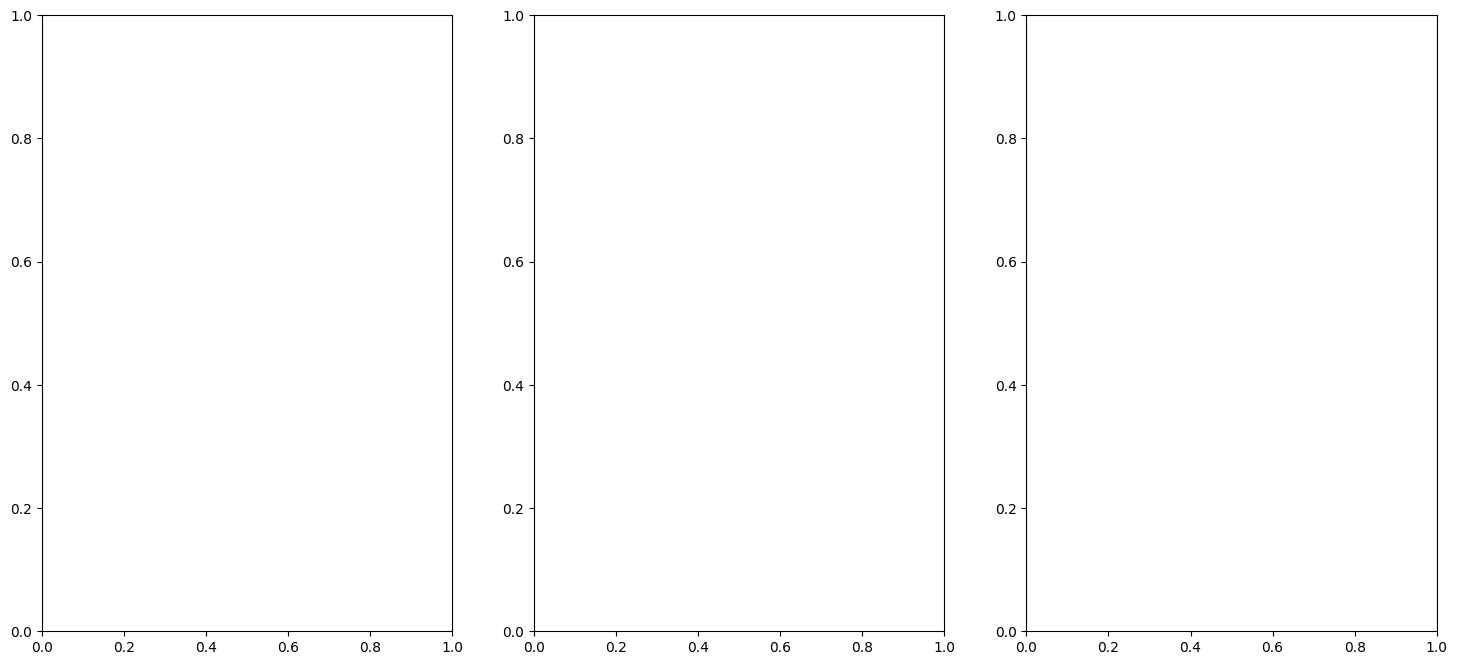

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 1 row, 2 columns
# Plot the second subplot
if False:
    ax = axes[0]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in nyc_graph.nodes():
        color = 'b'
        if node in important_points:
            color = 'r'
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color=color, s=10)

    ax = axes[1]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for n in graph.nodes():
        ax.scatter(graph.nodes[n]['x'], graph.nodes[n]['y'], color='b', s=10)
    # Plot the first subplot

    ax = axes[2]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in important_points:
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color='r', s=10)


        

    plt.tight_layout() 
    plt.savefig('cluster_visualization.png',dpi=300 )
    plt.show()


In [15]:
def distance(node1, node2):
    #print(node1, node2)
    try:    
        return nx.shortest_path_length(graph, node1, node2)
    except:
        return 1000000


In [16]:
def euc_distance(node1, node2):
    x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    a = np.array([x1, y1])
    b = np.array([x2, y2])
    dist = np.linalg.norm(a-b)
    return dist

In [17]:
working_important_nodes = important_points.copy()

In [18]:
working_important_nodes.sort(key=lambda node: graph.nodes[node]['y'] )

In [19]:
working_important_nodes[0]

588546891

In [20]:
# Sort important_nodes based on distance from the first node in the sorted list
working_important_nodes.sort(key=lambda node: euc_distance(588546891, node))

In [21]:
working_important_nodes

[588546891,
 42445357,
 42430044,
 42430041,
 4321748238,
 42451593,
 9166033061,
 9166033062,
 42428473,
 42430828,
 42436439,
 42440729,
 42440743,
 42437909,
 42430271,
 42437881,
 42442889,
 42437654,
 3786901738,
 9140654137,
 42432706,
 42428297,
 42449956,
 42450426,
 42435714,
 1241742563,
 6177439750,
 42447020,
 9177424867,
 42436492,
 42442463,
 42442469,
 42459137,
 42429334,
 42429342,
 1061531593,
 42442534,
 42447166,
 6223571524,
 42429552]

In [22]:
def create_graph_with_connections(working_important_nodes, k):
    G = nx.Graph()
    num_nodes = len(working_important_nodes)

    for i in range(num_nodes):
        for j in range(1, k+1):
            if i + j < num_nodes:
                G.add_edge(working_important_nodes[i], working_important_nodes[i+j])
            else:
                break

    return G
example = create_graph_with_connections(working_important_nodes, 1)

In [23]:
G = nx.Graph()


G.add_nodes_from(working_important_nodes)
for node1 in working_important_nodes:
    for node2 in working_important_nodes:
        if node1 != node2 and G.get_edge_data(node1, node2) is None:
            G.add_edge(node1, node2, weight=euc_distance(node1, node2))

T = nx.minimum_spanning_tree(G) 

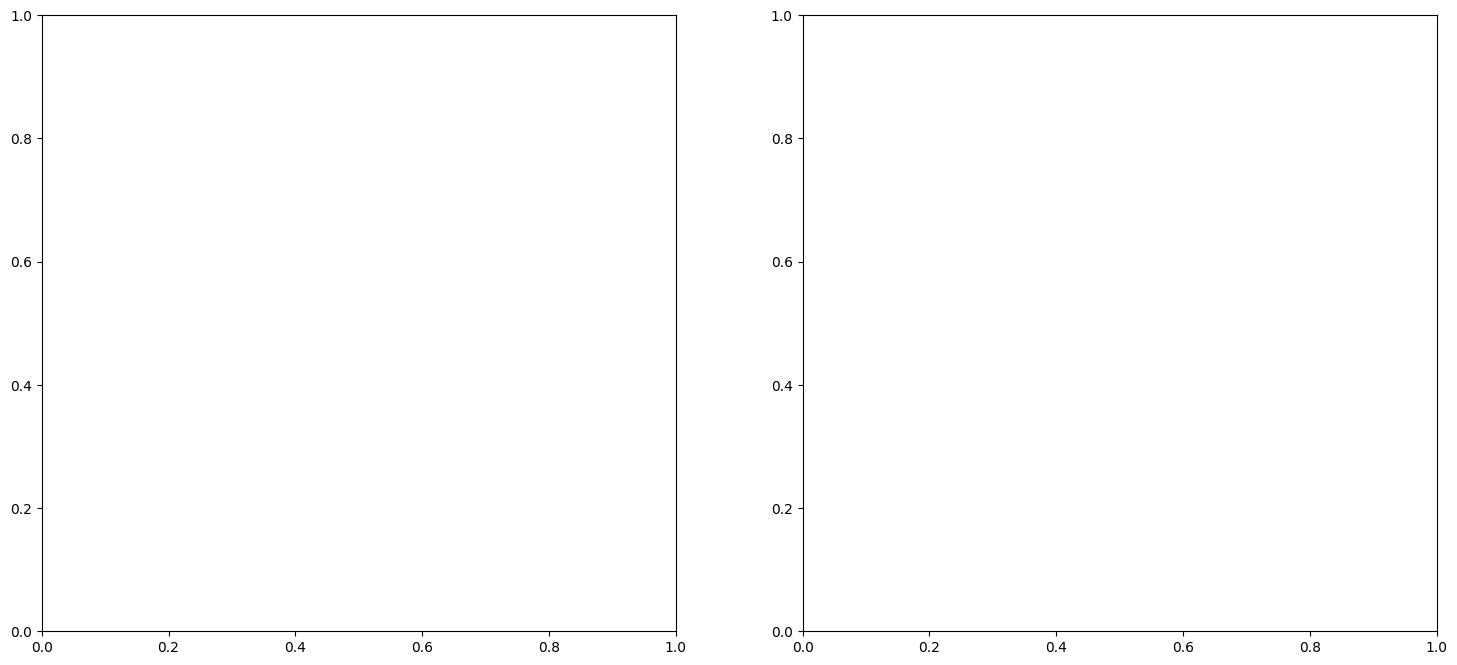

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns
if False:
    ax = axes[0]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in nyc_graph.nodes():
        color = 'b'
        if node in important_points:
            color = 'r'
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color=color, s=10)

    ax = axes[1]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node1, node2 in T.edges():
        
        
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        # Plot edge
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed

    plt.show()
    #ax.clear()

In [25]:
def nodes_directly_connected(graph, node, am = -1):
    connected_nodes = []
    for neighbor in graph.neighbors(node):
        if node in graph.neighbors(neighbor):
            connected_nodes.append(neighbor)
    return connected_nodes[:am]

In [26]:
def create_gts_graph(important_points,road_network, point = 0, r = 7, am=3):
    modified_G = nx.Graph()
    modified_G.add_nodes_from(important_points)
    

    #creates important connections
    immidiate_connections = {}
    for node in modified_G.nodes():
        immidiate_connections[node] = nodes_directly_connected(road_network, node)
    n_copy = list(modified_G.nodes()).copy()
    for n in n_copy:
        modified_G.add_nodes_from(immidiate_connections[n])
        modified_G.add_edges_from([(n, m) for m in immidiate_connections[n]])

    if point ==0:
        return modified_G
    
    for i in range(r):
        immidiate_connections = {}
        for node in modified_G.nodes():
            immidiate_connections[node] = nodes_directly_connected(road_network, node, am=am)
        n_copy = list(modified_G.nodes()).copy()
        for n in n_copy:
            modified_G.add_nodes_from(immidiate_connections[n])
            modified_G.add_edges_from([(n, m) for m in immidiate_connections[n]])
    
    if point==1:
        return modified_G
    
    nodes_to_remove = ["a"]
    while(len(nodes_to_remove)>0):
        nodes_to_remove = [node for node, degree in dict(modified_G.degree()).items() if degree == 1 and node not in important_points]
        # Remove those nodes from the graph
        modified_G.remove_nodes_from(nodes_to_remove)
    
    return modified_G
    

In [27]:
modified_G = create_gts_graph(important_points,nyc_graph, point = 0)

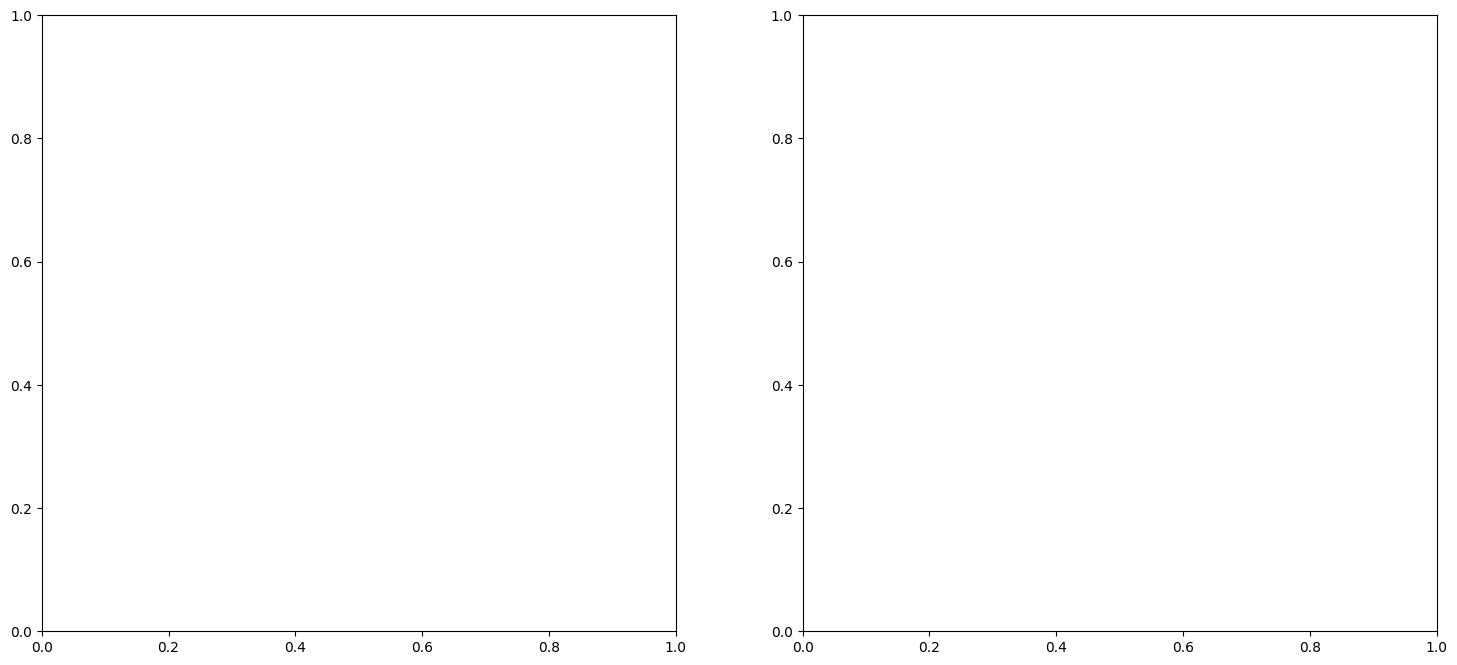

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns
if False:
    ax = axes[0]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in nyc_graph.nodes():
        color = 'b'
        if node in important_points:
            color = 'r'
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color=color, s=10)

    ax = axes[1]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node1, node2 in T.edges():
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        # Plot edge
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed
        if node1 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node1]['x'], graph.nodes[node1]['y'], color=color, s=10)
        if node2 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node2]['x'], graph.nodes[node2]['y'], color=color, s=10)

        

    plt.show()
    #ax.clear()

In [29]:
len(list(modified_G.nodes()))

116

In [30]:
modified_G = create_gts_graph(important_points,nyc_graph, point = 1, r = 7, am=3)

In [31]:
len(list(modified_G.nodes()))

477

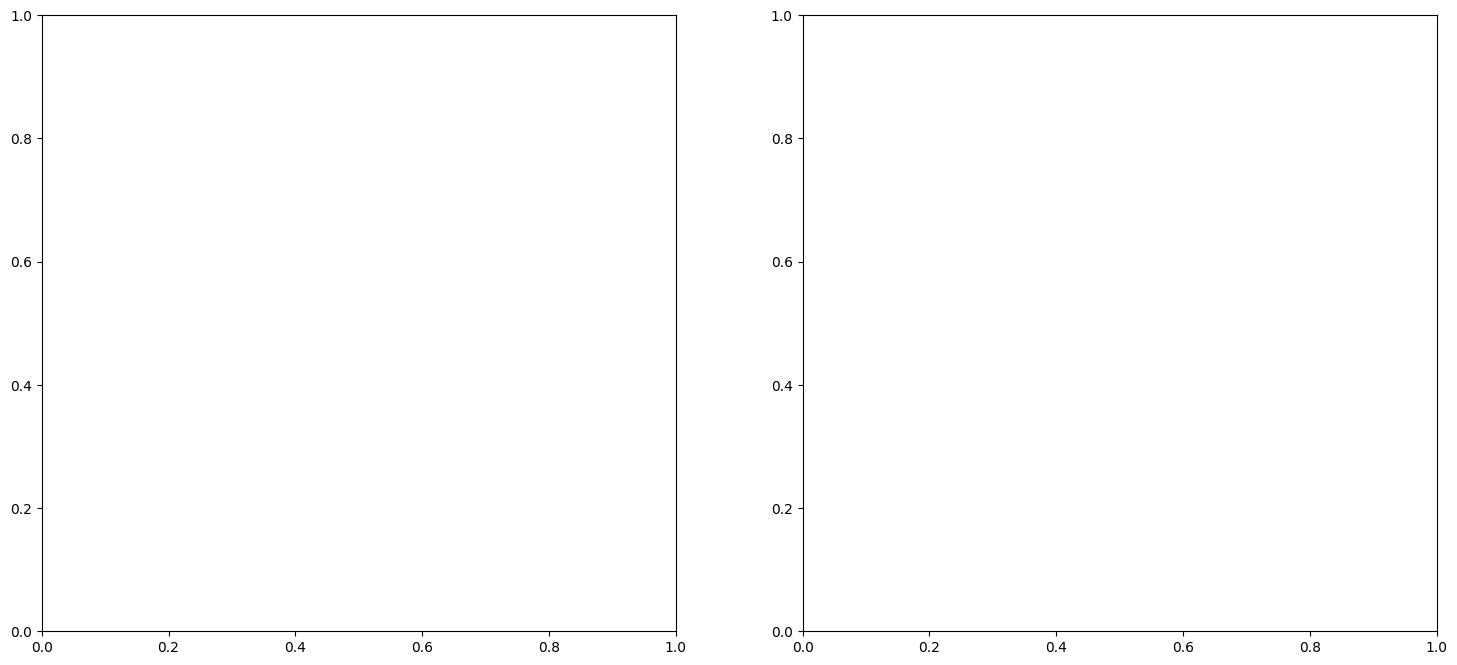

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns
if False:
    ax = axes[0]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in nyc_graph.nodes():
        color = 'b'
        if node in important_points:
            color = 'r'
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color=color, s=10)

    ax = axes[1]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node1, node2 in modified_G.edges():
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        # Plot edge
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed
        if node1 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node1]['x'], graph.nodes[node1]['y'], color=color, s=10)
        if node2 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node2]['x'], graph.nodes[node2]['y'], color=color, s=10)

        

    plt.show()
#ax.clear()

# Remove terminal nodes

In [33]:
modified_G = create_gts_graph(important_points,nyc_graph, point = 2, r = 7, am=3)

In [34]:
len(modified_G.nodes)

475

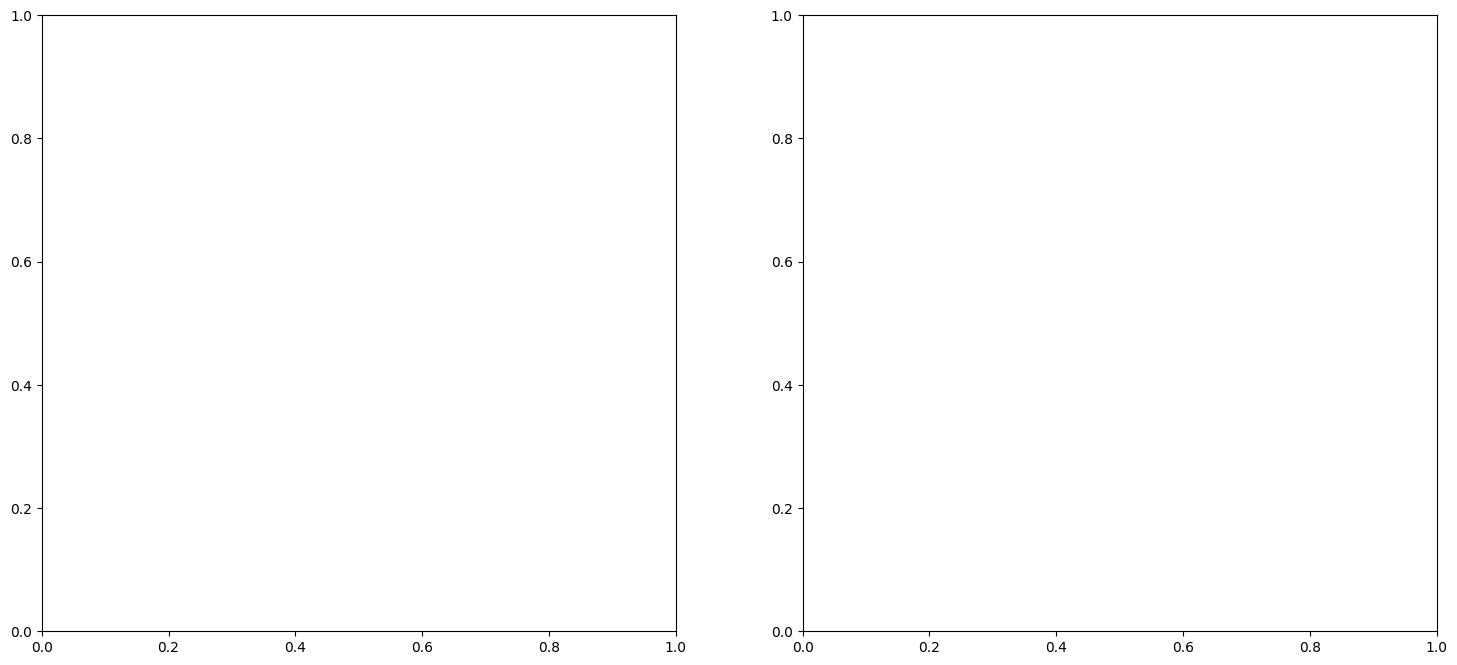

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns
if False:
    ax = axes[0]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node in nyc_graph.nodes():
        color = 'b'
        if node in important_points:
            color = 'r'
        ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color=color, s=10)

    ax = axes[1]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node1, node2 in modified_G.edges():
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        # Plot edge
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed
        if node1 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node1]['x'], graph.nodes[node1]['y'], color=color, s=4)
        if node2 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node2]['x'], graph.nodes[node2]['y'], color=color, s=4)

        

    plt.show()
#ax.clear()

In [36]:
len(modified_G.edges)

772

In [37]:
len(nyc_graph.edges)

1622

# Adding node and edge info

In [38]:
for n in modified_G.nodes():
    a = nyc_graph.nodes[n]
    b = modified_G.nodes[n]
    modified_G.nodes[n]["depot"] = a["depot"]


In [39]:
for u, v, d in nyc_graph.edges(data=True):
    if (u,v) in modified_G.edges():
        modified_G[u][v]["length"] = d["length"]
        modified_G[u][v]["maxspeed"] = d["maxspeed"]
        print(u,v, d)

42442664 42432999 {'name': 'West 160th Street', 'length': 57.055, 'oneway': True, 'lanes': nan, 'maxspeed': nan}
42442664 42442651 {'name': 'Amsterdam Avenue', 'length': 401.383, 'oneway': False, 'lanes': nan, 'maxspeed': nan}
42432999 42442664 {'name': 'West 160th Street', 'length': 57.055, 'oneway': True, 'lanes': nan, 'maxspeed': nan}
42432999 42432985 {'name': 'Saint Nicholas Avenue', 'length': 415.863, 'oneway': False, 'lanes': '3', 'maxspeed': 25}
42432985 42432999 {'name': 'Saint Nicholas Avenue', 'length': 415.863, 'oneway': False, 'lanes': '3', 'maxspeed': 25}
42432985 42432963 {'name': 'Saint Nicholas Avenue', 'length': 817.7499999999999, 'oneway': False, 'lanes': '3', 'maxspeed': 25}
42432985 42442651 {'name': 'West 155th Street', 'length': 155.88299999999998, 'oneway': False, 'lanes': nan, 'maxspeed': nan}
42432963 42432985 {'name': 'Saint Nicholas Avenue', 'length': 817.7499999999999, 'oneway': False, 'lanes': '3', 'maxspeed': 25}
42432963 42432929 {'name': 'Saint Nicholas

In [40]:
directed_graph = nx.DiGraph()
for node, data in modified_G.nodes(data=True):
    directed_graph.add_node(node, **data)

# Add edges from the undirected graph and copy over the "length" attribute
for u, v, data in modified_G.edges(data=True):
    directed_graph.add_edge(u, v, **data)
    directed_graph.add_edge(v, u, **data)  # Add the reverse edge with the same attributes



In [41]:
import pickle
with open("graph_from_routes_simplified.pkl", "wb") as f:
    pickle.dump(directed_graph, f, pickle.HIGHEST_PROTOCOL)

# TEST GTS

In [59]:
modified_G = create_gts_graph(important_points,graph_from_routes,  r = 7, am=3, point=2)

In [60]:
len(modified_G.edges())

772

In [78]:
dims = []
rs = [0,1,2,3,4,5,6,7, 8]
for r in rs:
    print(r)
    modified_G = create_gts_graph(important_points,nyc_graph,  r = r, am=3, point=2)
    dims += [len(modified_G.edges())]

0
1
2
3
4
5
6
7
8


In [79]:
print(" ".join([f"({xx}, {int(yy)})" for xx, yy in zip(rs, dims)]))

(0, 21) (1, 131) (2, 319) (3, 487) (4, 623) (5, 688) (6, 745) (7, 772) (8, 776)


In [74]:
modified_G = create_gts_graph(important_points,nyc_graph,  r = 1, am=3, point=2)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


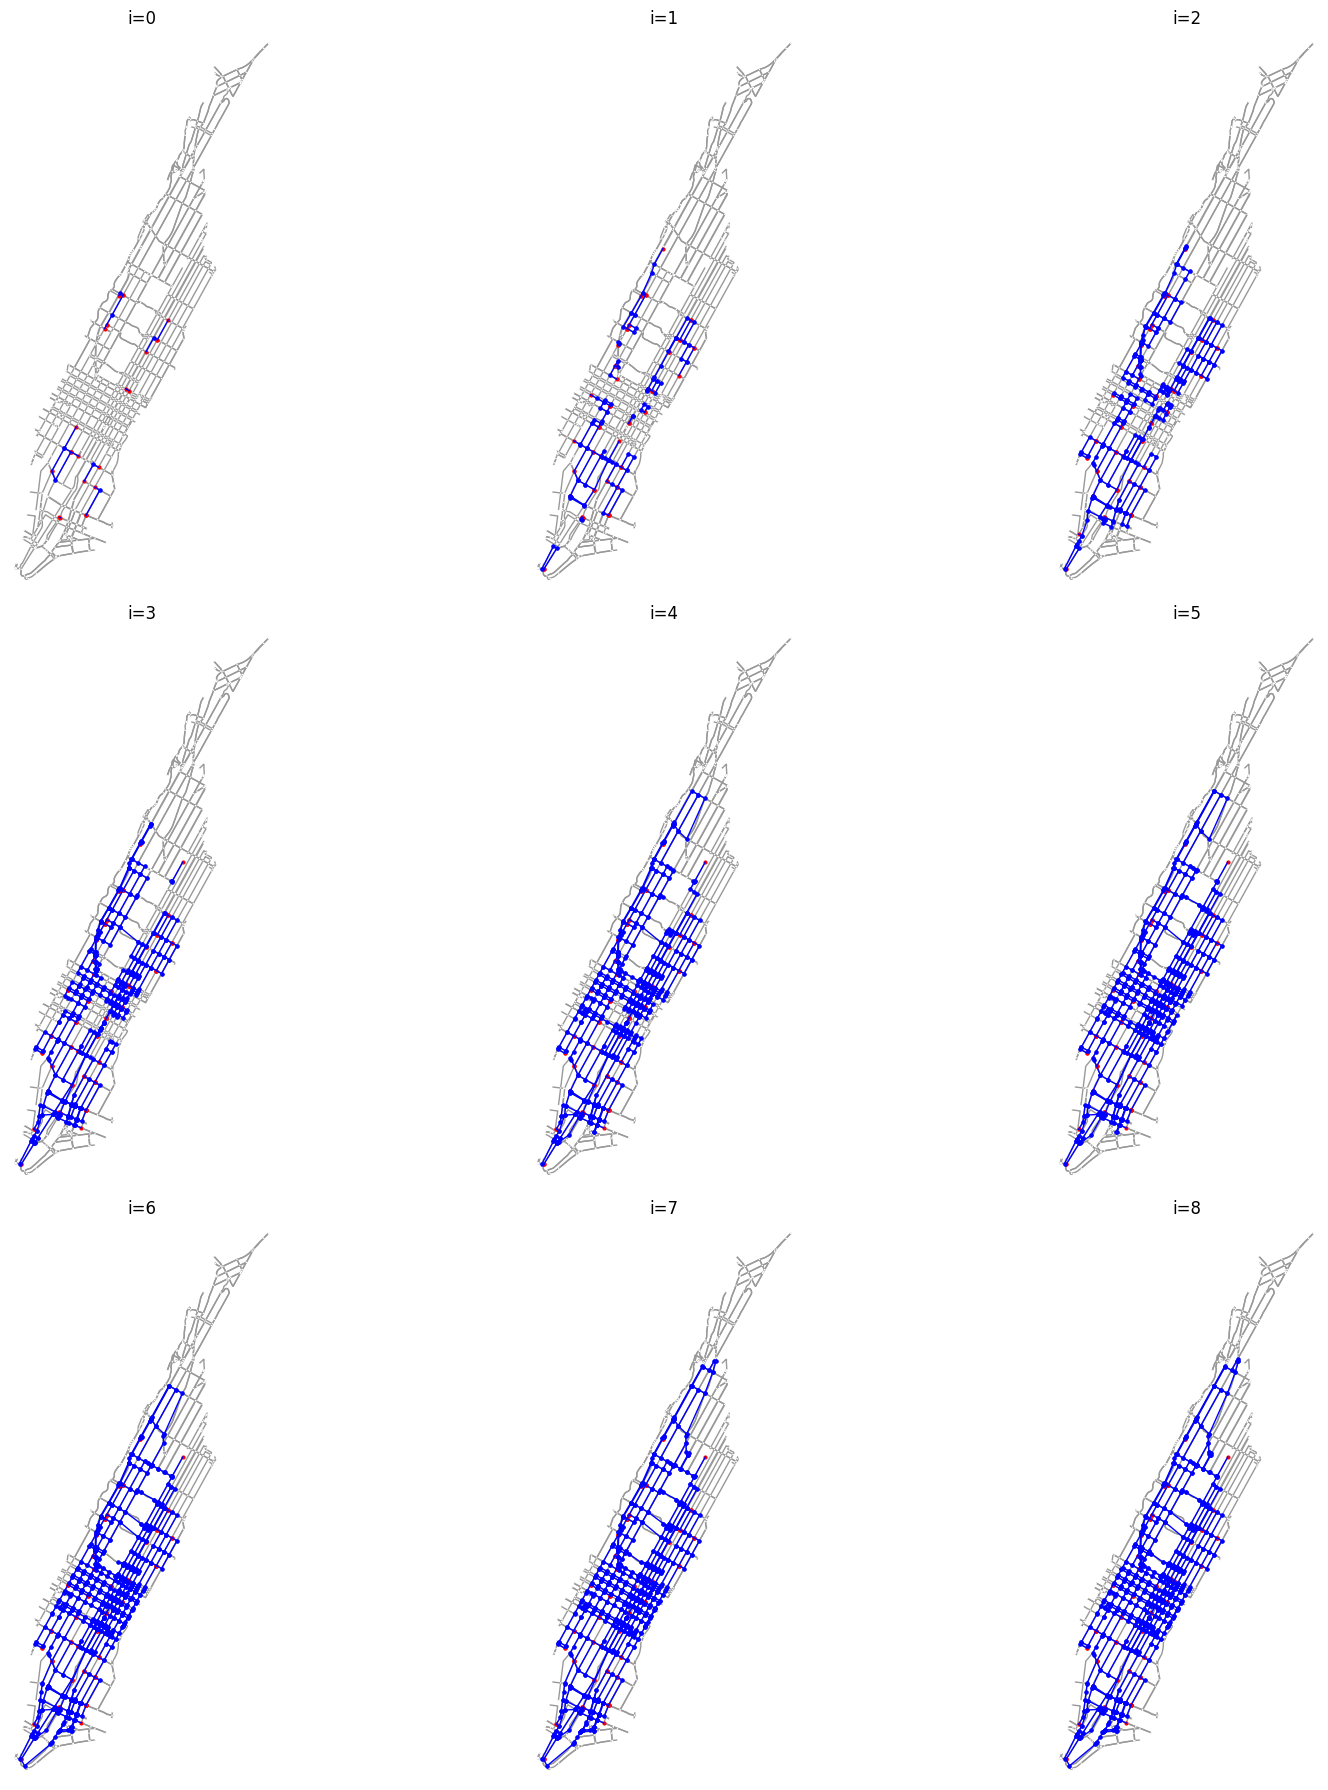

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # 3 rows, 3 columns
rs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for idx, r in enumerate(rs):
    modified_G = create_gts_graph(important_points, nyc_graph, r=r, am=3, point=2)
    row = idx // 3
    col = idx % 3
    print(row, col)
    ax = axes[row][col]
    ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
    for node1, node2 in modified_G.edges():
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
        # Plot edge
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  
        if node1 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node1]['x'], graph.nodes[node1]['y'], color=color, s=4)
        if node2 in important_points:
            color = "red"
        else:
            color = "blue"
        ax.scatter(graph.nodes[node2]['x'], graph.nodes[node2]['y'], color=color, s=4)

    ax.set_title("i=" + str(r))  # Add title
plt.tight_layout()
plt.savefig("evolution_nyc_plot.png", dpi=300)
#plt.show()